## Deep Learning Approach

In [185]:
#import appropriate packages

import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
import numpy
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score as cvs
from sklearn.model_selection import StratifiedShuffleSplit
import dask.dataframe as dd
from scipy.stats import skew
from sklearn import preprocessing
import lightgbm as lgb

from tab2img.converter import Tab2Img

#deep learning
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.callbacks import EarlyStopping
import torch
from torch import nn
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.impute import SimpleImputer

## Data Load

In [186]:
#colet_deep_data = pd.DataFrame()
#temp = pd.read_csv(r'E:\Deakin\SIT724\Data Set\Data\COLET\To upload\colet_deep_learning_data.csv', iterator = True, chunksize = 1000)
#colet_deep_data = pd.concat(temp, ignore_index=True)

In [187]:
#print(colet_deep_data.shape[0])

In [188]:
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

#colet_deep_data.isnull().sum(axis=0)

In [189]:
# Identify number of entrires for each class/participant

#class balancing? 

# GAZE

In [190]:
#check other COLET dataframes
colet_gaze = pd.read_csv(r'E:\Deakin\SIT724\Data Set\Data\COLET\To upload\colet_gaze_concat.csv')


In [191]:
#remove missing values

colet_gaze = colet_gaze.dropna()

In [192]:
#reset this as we are working with the index 

colet_gaze = colet_gaze.reset_index()

In [193]:
## Testing below

Test the below: 

- get the rolling feature value for the window, and then this becomes its own feature 

- apply the rolling using the windows created 

- class imbalance 

In [194]:
#calculate the difference between the earliest and latest timestamp by participant and task

#colet_gaze['index_diff']= colet_gaze.reset_index().groupby(['file', 'task'])['index'].transform(lambda x: x.max() - x.min())

In [195]:
#colet_gaze['window_size'] = round(colet_gaze['index_diff']/6)

In [196]:
#if between min and min + window_size then 1

In [197]:
# Create a new field 'window' with overlapping windows
#colet_gaze['window'] = colet_gaze.groupby(['file', 'task'])['index'].transform(lambda x: pd.Series(range(1, len(x) - 1)).rolling(window=int(colet_gaze['window_size'].iloc[0]), min_periods=1).apply(lambda y: y.iloc[-1] if not y.empty else None))

In [198]:
# Define the window size
#window_size = 5

# Group by 'file' and 'task', and calculate the window based on the index
#colet_gaze['window'] = colet_gaze.groupby(['file', 'task']).apply(lambda x: pd.RangeIndex(start=1, stop=len(x)+1) + window_size).values


In [199]:
#colet_gaze[colet_gaze['file'] == 'Task1_Subject_9.xlsx']

import pandas as pd

# Assuming your DataFrame is named colet_gaze and contains 'index', 'file', and 'task' columns

# Define the window function
def get_window_number(index):
    group_size = 3
    window_size = 5

    if index % window_size == 0:
        return 1
    else:
        group_index = (index // window_size) * group_size
        if index >= group_index and index < group_index + window_size:
            return (index - group_index) // group_size + 1
        else:
            return None

# Group by 'file' and 'task' and create window columns
grouped = colet_gaze.groupby(['file', 'task'])

for group_name, group_data in grouped:
    for i in range(1, 6):  # Assuming 5 windows
        window_col = f'window_{i}_{group_name[0]}_{group_name[1]}'
        colet_gaze.loc[group_data.index, window_col] = group_data['index'].apply(lambda x: 1 if get_window_number(x) == i else 0)

colet_gaze

In [200]:
## Testing above 

In [201]:
#calculate the difference between the earliest and latest timestamp by participant and task

colet_gaze['timestamp_diff']= (colet_gaze.groupby(['file', 'task'])['gaze_timestamp'].transform('max')-
             colet_gaze.groupby(['file', 'task'])['gaze_timestamp'].transform('min'))

In [202]:
#create an even number of window sizes

colet_gaze['window_size'] = 100
#colet_gaze['window_size'] = round(colet_gaze['timestamp_diff']/16)

In [203]:
# create a fixed window size

#
#max_category_n = 16
max_category_n = round(colet_gaze['timestamp_diff']/colet_gaze['window_size'] ).astype(int).max()

In [204]:
#include a 'min timestamp' for calculations below

colet_gaze['min_gaze_timestamp'] = colet_gaze.groupby(['file', 'task'])['gaze_timestamp'].transform('min')

In [ ]:
# Define a function to apply the logic and assign categories
def assign_category(row):
    max_category = max_category_n
    for i in range(1, max_category + 1):
        lower_bound = row['min_gaze_timestamp'] + (row['window_size'] * (i - 1))
        upper_bound = row['min_gaze_timestamp'] + (row['window_size'] * i)
        if row['gaze_timestamp'] >= lower_bound and row['gaze_timestamp'] <= upper_bound:
            return i
    return None

# Apply the function to create the 'category' column
colet_gaze['category'] = colet_gaze.apply(assign_category, axis=1)

#print(colet_gaze)

In [ ]:
colet_gaze

In [ ]:
#check if it's applyign correctly

print(colet_gaze[colet_gaze['file'] == 'Task1_Subject_1.xlsx']['category'].unique())

# PUPIL

In [ ]:
colet_pupil = pd.read_csv(r'E:\Deakin\SIT724\Data Set\Data\COLET\To upload\colet_pupil_concat.csv')
colet_pupil.isnull().sum(axis=0)

In [ ]:
#drop missing values
colet_pupil = colet_pupil.dropna()

In [ ]:
#calculate the difference between the earliest and latest timestamp by participant and task

colet_pupil['timestamp_diff']= (colet_pupil.groupby(['file', 'task'])['pupil_timestamp'].transform('max')-
             colet_pupil.groupby(['file', 'task'])['pupil_timestamp'].transform('min'))

In [ ]:
#create an even number of window sizes
colet_pupil['window_size'] = 100

#colet_pupil['window_size'] = round(colet_pupil['timestamp_diff']/16)

In [ ]:
# create a fixed window size


#max_category_n = 16

max_category_n = round(colet_pupil['timestamp_diff']/colet_pupil['window_size']).astype(int).max()

In [ ]:
#include a 'min timestamp' for calculations below

colet_pupil['min_pupil_timestamp'] = colet_pupil.groupby(['file', 'task'])['pupil_timestamp'].transform('min')

In [ ]:
# Define a function to apply the logic and assign categories
def assign_category(row):
    max_category = max_category_n
    for i in range(1, max_category + 1):
        lower_bound = row['min_pupil_timestamp'] + (row['window_size'] * (i - 1))
        upper_bound = row['min_pupil_timestamp'] + (row['window_size'] * i)
        if row['pupil_timestamp'] >= lower_bound and row['pupil_timestamp'] <= upper_bound:
            return i
    return None

# Apply the function to create the 'category' column
colet_pupil['category'] = colet_pupil.apply(assign_category, axis=1)



In [ ]:
#check if it's applyign correctly

print(colet_pupil[colet_pupil['file'] == 'Task1_Subject_1.xlsx']['category'].unique())

# BLINK

In [ ]:
colet_blink = pd.read_csv(r'E:\Deakin\SIT724\Data Set\Data\COLET\To upload\colet_blink_concat.csv')
colet_blink.isnull().sum(axis=0)

In [ ]:
#calculate the difference between the earliest and latest timestamp by participant and task

colet_blink['timestamp_diff']= (colet_blink.groupby(['file', 'task'])['start_timestamp'].transform('max')-
             colet_blink.groupby(['file', 'task'])['start_timestamp'].transform('min'))

In [ ]:
#create an even number of window sizes

colet_blink['window_size'] = 100
#colet_blink['window_size'] = round(colet_blink['timestamp_diff']/16)

In [ ]:
#create a fixed window size

max_category_n = round(colet_blink['timestamp_diff']/colet_blink['window_size']).astype(int).max()
#max_category_n = 16

In [ ]:
#include a 'min timestamp' for calculations below

colet_blink['min_blink_timestamp'] = colet_blink.groupby(['file', 'task'])['start_timestamp'].transform('min')

In [ ]:
# Define a function to apply the logic and assign categories
def assign_category(row):
    max_category = max_category_n
    for i in range(1, max_category + 1):
        lower_bound = row['min_blink_timestamp'] + (row['window_size'] * (i - 1))
        upper_bound = row['min_blink_timestamp'] + (row['window_size'] * i)
        if row['start_timestamp'] >= lower_bound and row['start_timestamp'] <= upper_bound:
            return i
    return None

# Apply the function to create the 'category' column
colet_blink['category'] = colet_blink.apply(assign_category, axis=1)



In [ ]:
colet_blink

# ANNOTATION

In [ ]:
colet_annot = pd.read_csv(r'E:\Deakin\SIT724\Data Set\Data\COLET\To upload\colet_annot_concat.csv')
colet_annot.isnull().sum(axis=0)

In [ ]:
#only really need mean_1 for the DV
colet_annot = colet_annot[['file', 'task', 'mean_1']]

### no need to do any additional work on annotation, but do need to merge it to the dataframes at the end

# Additional features to allow for aggregation by windows

# Gaze features

## Fixations and Saccades

In [ ]:
colet_gaze

In [ ]:
#get the difference between the previous value for each row

colet_gaze.sort_values(['file', 'gaze_timestamp', 'task', 'category'], inplace=True)
colet_gaze['gaze_diff'] = colet_gaze.groupby(['file', 'task', 'category'])['gaze_timestamp'].diff()
colet_gaze['x_diff'] = colet_gaze.groupby(['file', 'task', 'category'])['gaze_point_3d_x'].diff()
colet_gaze['y_diff'] = colet_gaze.groupby(['file', 'task', 'category'])['gaze_point_3d_y'].diff()
colet_gaze['z_diff'] = colet_gaze.groupby(['file', 'task', 'category'])['gaze_point_3d_z'].diff()

In [ ]:
#square x, y and z

colet_gaze['x_diff^2'] = colet_gaze['x_diff']**2
colet_gaze['y_diff^2'] = colet_gaze['y_diff']**2
colet_gaze['z_diff^2'] = colet_gaze['z_diff']**2

In [ ]:
#sum x y and z
column_names = ['x_diff^2','y_diff^2','z_diff^2']

colet_gaze['sum']= colet_gaze[column_names].sum(axis=1)

In [ ]:
#take sqrt of this value

colet_gaze['sqrt']= np.sqrt(colet_gaze['sum'])

In [ ]:
#divide by displacement to obtain velocity

colet_gaze['velocity'] = colet_gaze['gaze_diff'] / colet_gaze['sqrt']

In [ ]:
# skewness of velocity

colet_gaze['skew_velocity'] = colet_gaze.groupby(['file', 'task', 'category'])['velocity'].transform(lambda x: x.skew())

# kurtosis of velocity

colet_gaze['kurtosis_velocity'] = colet_gaze.groupby(['file', 'task', 'category'])['velocity'].transform(lambda x: x.kurtosis())

In [ ]:
# skewness of duration

colet_gaze['skew_gaze_duration'] = colet_gaze.groupby(['file', 'task', 'category'])['gaze_diff'].transform(lambda x: x.skew())

#kurtosis of duration

colet_gaze['kurtosis_gaze_duration'] = colet_gaze.groupby(['file', 'task', 'category'])['gaze_diff'].transform(lambda x: x.kurtosis())

In [ ]:
#fixation flag

colet_gaze['fixation_flag'] = np.where((colet_gaze['velocity'] < 0.45) & (colet_gaze['gaze_diff']) > 0.55, 1, 0)

In [ ]:
#grouping fixations (as the authors did the same thing)

colet_gaze['fix_group'] = colet_gaze.groupby(['file', 'task', 'category'])['fixation_flag'].diff().abs().cumsum().fillna(0).astype(int) + 1

In [ ]:
#counting fixations 1 time! 

colet_gaze['fixations_count'] = colet_gaze.groupby(['file', 'task', 'category'])['fix_group'].transform('nunique')

In [ ]:
#fixations per second

colet_gaze['fix_per_sec'] = colet_gaze['fixations_count'] / colet_gaze['timestamp_diff']

In [ ]:
#saccade flag
colet_gaze['saccade_flag'] = np.where((colet_gaze['velocity'] > 0.45) & (colet_gaze['gaze_diff']) < 0.55, 1, 0)

In [ ]:
#saccades per second
colet_gaze['saccade_sum'] = colet_gaze.groupby(['file', 'task', 'category'])['saccade_flag'].transform('sum')

colet_gaze['sac_per_sec'] = colet_gaze['saccade_sum'] / colet_gaze['timestamp_diff']

In [ ]:
#max eye movement velocity
colet_gaze['max_movement_velocity'] = colet_gaze.groupby(['file', 'task', 'category'])['velocity'].transform('max')

#min eye movement velocity
colet_gaze['min_movement_velocity'] = colet_gaze.groupby(['file', 'task', 'category'])['velocity'].transform('min')

In [ ]:
#skewness kurtosis can't work on nulls
colet_gaze = colet_gaze.dropna()

#skewness max velocity

colet_gaze['skew_max_velocity'] = colet_gaze.groupby(['task', 'category'])['max_movement_velocity'].transform(lambda x: x.skew())

#skewness max kurtosis

colet_gaze['kurtosis_max_velocity'] = colet_gaze.groupby(['task', 'category'])['max_movement_velocity'].transform(lambda x: x.kurtosis())

#skewness min velocity

colet_gaze['skew_min_velocity'] = colet_gaze.groupby(['task', 'category'])['min_movement_velocity'].transform(lambda x: x.skew())

#kurtosis min velocity

colet_gaze['kurtosis_min_velocity'] = colet_gaze.groupby(['task', 'category'])['min_movement_velocity'].transform(lambda x: x.kurtosis())

In [ ]:
colet_gaze

In [ ]:
#select columns of interest 
colet_gaze = colet_gaze[['file', 'task', 'category', 'fixations_count', 'sac_per_sec', 'fix_per_sec', 'max_movement_velocity', 'min_movement_velocity', 'saccade_sum'
                         , 'skew_max_velocity', 'kurtosis_max_velocity', 'skew_min_velocity', 'kurtosis_min_velocity'
                        ]]

In [ ]:
#remove duplicates
colet_gaze = colet_gaze.drop_duplicates()

In [ ]:
#the max values are resulting in infinite values, instead replacing these infinite values with the next highest max value

# Replace 'inf' values with the maximum 'max_movement_velocity' grouped by 'file', 'task', and 'category'
colet_gaze['max_movement_velocity'] = colet_gaze['max_movement_velocity'].replace([np.inf], np.nan)  # Replace 'inf' with nan temporarily

max_values = colet_gaze.groupby(['file', 'task', 'category'])['max_movement_velocity'].transform('max')
colet_gaze['max_movement_velocity'] = colet_gaze['max_movement_velocity'].fillna(max_values)  # Fill nan values with group max

In [ ]:
colet_gaze.to_csv('colet_gaze_features.csv', index = False)

In [ ]:
colet_gaze

# Pupil Features

## Pupil size

In [ ]:
#avg diameter, max diameter, min diameter

#avg diameter
colet_pupil['avg_pupil_diameter'] = colet_pupil.groupby(['file', 'task', 'category'])['diameter'].transform('mean')

#max diameter
colet_pupil['max_pupil_diameter'] = colet_pupil.groupby(['file', 'task', 'category'])['diameter'].transform('max')

#min diameter
colet_pupil['min_pupil_diameter'] = colet_pupil.groupby(['file', 'task', 'category'])['diameter'].transform('min')

In [ ]:
#skewness kurtosis can't work on nulls
colet_pupil = colet_pupil.dropna()

#skewness min diameter

colet_pupil['skew_min_pupil_diameter'] = colet_pupil.groupby(['task', 'category'])['min_pupil_diameter'].transform(lambda x: x.skew())

#kurtosis min diameter

colet_pupil['kurtosis_min_pupil_diamaeter'] = colet_pupil.groupby(['task', 'category'])['min_pupil_diameter'].transform(lambda x: x.kurtosis())

#skewness max diameter

colet_pupil['skew_max_pupil_diameter'] = colet_pupil.groupby([ 'task', 'category'])['max_pupil_diameter'].transform(lambda x: x.skew())

#kurtosis max diameter

colet_pupil['kurtosis_max_pupil_diamaeter'] = colet_pupil.groupby(['task', 'category'])['max_pupil_diameter'].transform(lambda x: x.kurtosis())


In [ ]:
#select appropriate columns

colet_pupil = colet_pupil[['file', 'task', 'category', 'avg_pupil_diameter', 'max_pupil_diameter', 'min_pupil_diameter'
                           , 'skew_min_pupil_diameter', 'kurtosis_min_pupil_diamaeter', 'skew_max_pupil_diameter', 'kurtosis_max_pupil_diamaeter' 
                          ]]

In [ ]:
#remove duplicate rows as we have aggreated these already

colet_pupil = colet_pupil.drop_duplicates()

In [ ]:
colet_pupil.to_csv('colet_pupil_features.csv', index = False)

# Blink Features

In [ ]:
#identify length of blink by using the timestamps
colet_blink['blink_duration'] = colet_blink['end_timestamp'] - colet_blink['start_timestamp']

In [ ]:
#avg duration
colet_blink['avg_blink_duration'] = colet_blink.groupby(['file', 'task', 'category'])['blink_duration'].transform('mean')

#max duration
colet_blink['max_blink_duration'] = colet_blink.groupby(['file', 'task', 'category'])['blink_duration'].transform('max')

#min duration
colet_blink['min_blink_duration'] = colet_blink.groupby(['file', 'task', 'category'])['blink_duration'].transform('min')

In [ ]:
#skewness kurtosis can't work on nulls
colet_blink = colet_blink.dropna()


#skewness min duration

colet_blink['skew_min_blink_duration'] = colet_blink.groupby(['task', 'category'])['min_blink_duration'].transform(lambda x: x.skew())

#kurtosis min duration

colet_blink['kurtosis_min_blink_duration'] = colet_blink.groupby(['task', 'category'])['min_blink_duration'].transform(lambda x: x.kurtosis())

#skewness max duration

colet_blink['skew_max_blink_duration'] = colet_blink.groupby(['task', 'category'])['max_blink_duration'].transform(lambda x: x.skew())

#kurtosis max duration

colet_blink['kurtosis_max_blink_duration'] = colet_blink.groupby(['task', 'category'])['max_blink_duration'].transform(lambda x: x.kurtosis())

In [ ]:
colet_blink = colet_blink[['file', 'task', 'category', 'avg_blink_duration', 'max_blink_duration', 'min_blink_duration'
                           , 'skew_min_blink_duration', 'kurtosis_min_blink_duration', 'skew_max_blink_duration', 'kurtosis_max_blink_duration'
                          ]]

In [ ]:
colet_blink = colet_blink.drop_duplicates()

In [ ]:
colet_blink.to_csv('colet_blink_features.csv', index = False)

# Merge dataframes into one

In [ ]:
#gaze and pupil
df1 = pd.merge(colet_gaze, colet_pupil, how='outer', on=['file', 'task', 'category'])

#gaze+pupil and blink
df2 = pd.merge(df1, colet_blink, how='outer', on=['file', 'task', 'category'])

#adding on the annotations
colet_final_df = pd.merge(df2, colet_annot, how = 'outer', on = ['file', 'task'])

del df2
del df1

In [ ]:
colet_final_df.to_csv('colet_final_features.csv', index = False)

In [ ]:
colet_final_df

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print(colet_final_df.columns.tolist())

In [ ]:
# Reset display options to default
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

# Feature Analysis

## creating multiclass target variables

In [ ]:
#converting the mean_1 feature into a multiclass target variable for analysis

bins = [0, 29, 49, 100]
labels = ['1', '2', '3']
colet_final_df['mean_1'] = pd.cut(colet_final_df['mean_1'], bins, labels=labels)
colet_final_df

In [ ]:
# List of columns to exclude from filling missing values with mean
exclude_cols = ['file', 'task', 'category']  # Add the columns you want to exclude from filling NaN values

# Identify numeric columns to fill missing values with mean
numeric_cols = colet_final_df.select_dtypes(include=['number']).columns

# Iterate through each numeric column except the excluded columns
for col in numeric_cols:
    if col not in exclude_cols:
        colet_final_df[col] = colet_final_df[col].fillna(colet_final_df.groupby('file')[col].transform('mean'))

#filling missing values - can't do it over the whole dataframe as it tries to fill other fields! Only grouping by task, as we have already aggregated

colet_final_df['avg_blink_duration'] = colet_final_df['avg_blink_duration'].fillna(colet_final_df.groupby('file')['avg_blink_duration'].transform('mean'))
colet_final_df['sac_per_sec'] = colet_final_df['sac_per_sec'].fillna(colet_final_df.groupby('file')['sac_per_sec'].transform('mean'))
colet_final_df['fix_per_sec'] = colet_final_df['fix_per_sec'].fillna(colet_final_df.groupby('file')['fix_per_sec'].transform('mean'))
colet_final_df['max_movement_velocity'] = colet_final_df['max_movement_velocity'].fillna(colet_final_df.groupby('file')['max_movement_velocity'].transform('mean'))
colet_final_df['min_movement_velocity'] = colet_final_df['min_movement_velocity'].fillna(colet_final_df.groupby('file')['min_movement_velocity'].transform('mean'))
colet_final_df['avg_blink_duration'] = colet_final_df['avg_blink_duration'].fillna(colet_final_df.groupby('file')['avg_blink_duration'].transform('mean'))
colet_final_df['max_blink_duration'] = colet_final_df['max_blink_duration'].fillna(colet_final_df.groupby('file')['max_blink_duration'].transform('mean'))
colet_final_df['skew_min_blink_duration'] = colet_final_df['skew_min_blink_duration'].fillna(colet_final_df.groupby('file')['skew_min_blink_duration'].transform('mean'))
colet_final_df['skew_max_blink_duration'] = colet_final_df['skew_max_blink_duration'].fillna(colet_final_df.groupby('file')['skew_max_blink_duration'].transform('mean'))
colet_final_df['kurtosis_max_blink_duration'] = colet_final_df['kurtosis_max_blink_duration'].fillna(colet_final_df.groupby('file')['kurtosis_max_blink_duration'].transform('mean'))





In [ ]:
colet_final_df

In [ ]:
print(len(colet_final_df[colet_final_df['file'] == 'Task1_Subject_8.xlsx']))

In [ ]:
colet_final_df = colet_final_df.dropna()

In [ ]:
colet_final_df.reset_index()

In [ ]:
# seperating the target and input variables

colet_target = colet_final_df['mean_1']

colet_features = colet_final_df.drop(['mean_1', 'file', 'task'
                                      #,'kurtosis_min_pupil_diamaeter',	'skew_max_pupil_diameter',	'kurtosis_max_pupil_diamaeter', 'skew_min_blink_duration',	'kurtosis_min_blink_duration',	'skew_max_blink_duration',	'kurtosis_max_blink_duration', 'skew_max_velocity',	'kurtosis_max_velocity',	'skew_min_velocity'	,'kurtosis_min_velocity'
                                     ], axis=1)

In [ ]:
colet_features

In [ ]:
colet_features = colet_features.dropna()

In [ ]:
colet_features.dtypes

In [ ]:
np.any(np.isnan(colet_features))

In [ ]:
np.all(np.isfinite(colet_features))

In [ ]:
#scaling the data 

scaler = MinMaxScaler()
model = scaler.fit(colet_features)
colet_features = model.transform(colet_features)

In [ ]:
#test-train split

col_X_train, col_X_test, col_y_train, col_y_test = train_test_split(colet_features, colet_target, test_size=0.3, random_state=61)

In [ ]:
#fitting random forest to assist with feature importance - different to the KNN model earlier 

#naming features 0 to as many exist within the model
feature_names = [f"feature {i}" for i in range(col_X_train.shape[1])]


#including random state in here so that it can be reproduced - arbitrary number is used 
random_forest_classifier = RandomForestClassifier(random_state=14)
random_forest_classifier.fit(col_X_train, col_y_train)

#creating our MDI values using the random forest classifier 
feat_importances = random_forest_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest_classifier.estimators_], axis=0)

#plotting our MDI for features - this will make it easier to interpret 
forest_importances = pd.Series(feat_importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("MDI Feature Importance Random Forest")
ax.set_ylabel("MDI (Mean decrease in impurity)")
fig.tight_layout()

In [ ]:
# linear regression feature importance

# our model will be a linear regression model 
model = LinearRegression()
# fit the model
model.fit(col_X_train, col_y_train)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

# Converting tabular data to images

In [643]:
#https://www.kaggle.com/code/taranmarley/data-images-cnn

#reshape data (we have already scaled it early on)

y_scaler =  preprocessing.StandardScaler().fit(col_y_train.values.reshape(-1, 1))
y_scaled_train = y_scaler.transform(col_y_train.values.reshape(-1, 1))
y_scaled_test = y_scaler.transform(col_y_test.values.reshape(-1, 1))

In [179]:
#conversion to images

model = Tab2Img()
train_images = model.fit_transform(col_X_train, y_scaled_train)
val_images = model.transform(col_X_test)
test_images = model.transform(col_X_test)

ValueError: cannot reshape array of size 25 into shape (17,17)

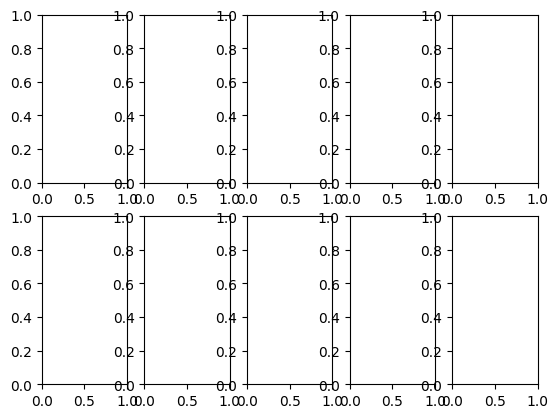

In [180]:
fig,ax = plt.subplots(2,5)
for i in range(10):
    nparray = test_images[i].reshape(17,17)
    image = Image.fromarray(nparray * 255)
    ax[i%2][i//2].imshow(image)
fig.show()

# Maching learning models

## SVM

In [ ]:
# parameters for the grid search
param_grid = {'C': [0.1, 1, 10, 100, 1000, 10000], 
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]} 

#verbose = 1 to limit the amount of output we see from python   
gridsearch = GridSearchCV(SVC(),  param_grid, refit = True, cv = 10, verbose = 1, scoring='accuracy')
  
# fitting the gridsearch onto the model - using our testing data
gridsearch.fit(col_X_train, col_y_train)

In [ ]:
# optimal hyperparameters 
print(gridsearch.best_params_)
  
# best estimators
print(gridsearch.best_estimator_)

#save parameters to input into the model 
svm_colet_hyper = gridsearch.best_params_
best_score = gridsearch.best_score_

In [ ]:
#creating the SVC model

# using hyperparmaters identified earlier, we can call these as we saved them, saves a lot of time 
support_vc=SVC(C = svm_colet_hyper['C'], 
gamma=svm_colet_hyper['gamma'], 
kernel=svm_colet_hyper['kernel'], 
random_state = 52) 

# fit to training set
support_vc.fit(col_X_train,col_y_train)

# predictions on test set
y_pred=support_vc.predict(col_X_test)

#accuracy score
acc = accuracy_score(col_y_test,y_pred)

# F1 score

print(classification_report(col_y_test, y_pred, digits=4))

## CART

In [ ]:
decist = DecisionTreeClassifier(random_state=1)
# Createing our grid of hyperparameters - these are what will be searched by the grid 
params_decist = {
'max_depth': [2, 3,4,5, 6,8,10],
'min_samples_leaf': [0.04, 0.06, 0.08, 0.10,0.2,0.4],
'max_features': [0.2, 0.4,0.6, 0.8, 0.10,0.2,0.4]
}
# doing our cross fold search through the grid, checkign by accuracy 
#making use of gridsearch to find the optimal values - note verbose = 1 to limit the amount of output we see from python  
grid_decist = GridSearchCV(estimator=decist,
param_grid=params_decist,
scoring=
'accuracy'
,
cv=10,
n_jobs=-1)

In [ ]:
# Fitting the grid to our training data to then find our best hyperparameters 
grid_decist.fit(col_X_train, col_y_train)

#print best hyperparameters as found earlier - these will be used to run our model 
cart_colet_hyper = grid_decist.best_params_
print('Best hyerparameters for CART:', cart_colet_hyper)

In [ ]:
#create teh final model with our best hyperparameters 

final_model = DecisionTreeClassifier(max_depth = cart_colet_hyper['max_depth'], 
                                     max_features = cart_colet_hyper['max_features'], min_samples_leaf = cart_colet_hyper['min_samples_leaf'], random_state = 50)
final_model.fit(col_X_train, col_y_train)

print(final_model)

#test them 
expected_y  = col_y_test
predicted_y = final_model.predict(col_X_test)
#predicting values from logistic regression and viewing our test score
y_pred = final_model.predict(col_X_test)
print('Accuracy of CART classifier on test set: {:.4f}'.format(final_model.score(col_X_test, col_y_test)))

# F1 score
print(classification_report(col_y_test, y_pred, digits=4))

## GNB

In [ ]:
#set cross validation method
cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=10, 
                                    random_state=52)

In [ ]:
#create model and gridsearch using cv method noted above 
model = GaussianNB()
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=model, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

Data_transformed = PowerTransformer().fit_transform(col_X_test)

gs_NB.fit(col_X_test, col_y_test)

#get best parametesr 
gnb_colet_params = gs_NB.best_params_

In [ ]:
nb = GaussianNB(var_smoothing = gnb_colet_params['var_smoothing'])
nb.fit(col_X_test, col_y_test)
# make predictions on test set
y_pred=nb.predict(col_X_test)

#confm = confusion_matrix(col_y_test, y_pred)
acc = accuracy_score(col_y_test,y_pred)

print(classification_report(col_y_test, y_pred, digits=4))

## Light GBM


colet_gbm = lgb.LGBMClassifier(verbose=0)

cgbm_param_grid = {'learning_rate': [0.2, 0.1, 0.05, 0.01, 0.001, 0.001], 'n_estimators': [50, 100, 150, 200, 250, 300, 400, 500], 'max_depth': [1, 3, 5, 7, 10],  }

gs_cgbm = GridSearchCV(estimator=colet_gbm, param_grid=cgbm_param_grid, cv=cv_method)

gs_cgbm.fit(col_X_train, col_y_train)

gbm_colet_params = gs_cgbm.best_params_

In [ ]:
colet_gbm = lgb.LGBMClassifier(learning_rate = gbm_colet_params['learning_rate'], max_depth = gbm_colet_params['max_depth'], n_estimators = gbm_colet_params['n_estimators'], verbose=0)
colet_gbm.fit(col_X_train, col_y_train, eval_set=[(col_X_train, col_y_train),(col_X_test, col_y_test)])

# TabNet

# Define your TabNetClassifier with custom parameters
classifier = TabNetClassifier(
    seed=42,
    optimizer_params=dict(lr=0.01),  # Modify the learning rate here (lr=0.01 as an example)
    scheduler_params={"step_size": 10, "gamma": 0.9},  # Learning rate scheduler parameters
    verbose=1  # Set verbosity level
)

In [ ]:
classifier = TabNetClassifier(seed=42, verbose = 0)
classifier.fit(X_train=col_X_train, y_train=col_y_train,
               patience=5,max_epochs=10000,
               eval_metric=['auc'])

In [ ]:
y_pred=classifier.predict(col_X_test)
print(classification_report(col_y_test, y_pred))